## Project Overview
This project implements an enhanced sentiment analysis model by leveraging multi-layer features from BERT transformer blocks. Instead of using only the final layer's representation, this approach extracts and combines features from all encoder layers to create a more robust text representation for sentiment classification.

## Key Features
- **Multi-layer Feature Extraction**: Extracts embeddings from all four BERT encoder layers
- **Feature Fusion**: Combines layer outputs using global average pooling and concatenation
- **Deep Classifier Network**: Implements a multi-layer neural network with batch normalization and dropout
- **IMDB Dataset**: Trained and evaluated on the widely-used IMDB movie reviews dataset

# Install and load libraries

In [ ]:
# Download tensorflow datasets
!pip install tensorflow_datasets

# A dependency of the preprocessing for BERT inputs
!pip install tensorflow_text
!pip install tensorflow_hub

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Load preprocessor and encoder to test
preprocessor = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_model = hub.load('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1')

In [ ]:
# Test with a simple example to verify they work
test_text = ['This is a test']
text_preprocessed = preprocessor(test_text)
bert_outputs = bert_model(text_preprocessed)
print("BERT test successful!")
print(f"Number of encoder layers: {len(bert_outputs['encoder_outputs'])}")

BERT test successful!
Number of encoder layers: 4


# Load the dataset


In [ ]:
# 1.1 Tokenize and preprocess the IMDB dataset
print("Loading IMDB dataset...")
train_data, val_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:80%]', 'train[80%:]', 'test'),
    as_supervised=True,
    batch_size=64  # Smaller batch size
)

# Define a mapping function to preprocess the data
def map_function(text, label):
    # 1.1 Preprocess text using BERT preprocessing
    preprocessed = preprocessor(text)

    # 1.2 Extract the embedding feature vectors from each of the four encoder blocks
    encoder_outputs = bert_model(preprocessed)['encoder_outputs']

    # Apply pooling to each layer's output
    pooled_outputs = []
    for layer_output in encoder_outputs:
        # Apply global average pooling
        pooled = tf.reduce_mean(layer_output, axis=1)
        pooled_outputs.append(pooled)

    # 1.3 Combine the embedding feature vectors from the four encoder blocks
    combined_output = tf.concat(pooled_outputs, axis=-1)

    return combined_output, label

Loading IMDB dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.ER9HFJ_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.ER9HFJ_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.ER9HFJ_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# 1.4 Construct the classification model using the combined embedding feature vector
classifier = tf.keras.Sequential([

        tf.keras.layers.InputLayer(input_shape=(4*128,)),

        # First dense block with higher capacity
        tf.keras.layers.Dense(256, activation=None),  # Larger layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4),  # More aggressive dropout

        # Second dense block
        tf.keras.layers.Dense(128, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.3),

        # Third dense block
        tf.keras.layers.Dense(64, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.2),

        # Output layer
        tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the classifier with a lower learning rate
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4),  # Lower learning rate
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
# Create TF datasets with preprocessed data
def preprocess_dataset(dataset):
    return dataset.map(
        map_function,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

# Use more data - 1000 examples for training
train_data_subset = train_data.take(3000)
val_data_subset = val_data.take(300)

In [ ]:
# Preprocess datasets
print("Preprocessing datasets (this will take a few minutes)...")
train_processed = preprocess_dataset(train_data_subset)
val_processed = preprocess_dataset(val_data_subset)

# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True
)

# Train the classifier for more epochs
print("Training classifier...")
history = classifier.fit(
    train_processed,
    validation_data=val_processed,
    epochs=15,
    callbacks=[early_stopping]
)

Preprocessing datasets (this will take a few minutes)...
Training classifier...
Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 165s 490ms/step - accuracy: 0.6150 - loss: 0.6700 - val_accuracy: 0.7278 - val_loss: 0.5430
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 183s 443ms/step - accuracy: 0.6937 - loss: 0.5842 - val_accuracy: 0.7302 - val_loss: 0.5333
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 435ms/step - accuracy: 0.7063 - loss: 0.5626 - val_accuracy: 0.7302 - val_loss: 0.5298
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 447ms/step - accuracy: 0.7191 - loss: 0.5480 - val_accuracy: 0.7330 - val_loss: 0.5258
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 156s 491ms/step - accuracy: 0.7231 - loss: 0.5436 - val_accuracy: 0.7348 - val_loss: 0.5240
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 456ms/step - accuracy: 0.7306 - loss: 0.5372 - val_accuracy: 0.7344 - val_loss: 0.5225
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 151s 480ms/step - accuracy: 0.7335 - loss: 0.5287 - val_accuracy: 0.7332 - val_loss: 0.5

In [ ]:
# Save the trained model
print("Saving the trained model...")
model_save_path = "./sentiment_classifier_model_4.keras"
classifier.save(model_save_path)
print(f"Model saved to {model_save_path}")

Saving the trained model...
Model saved to ./sentiment_classifier_model_4.keras


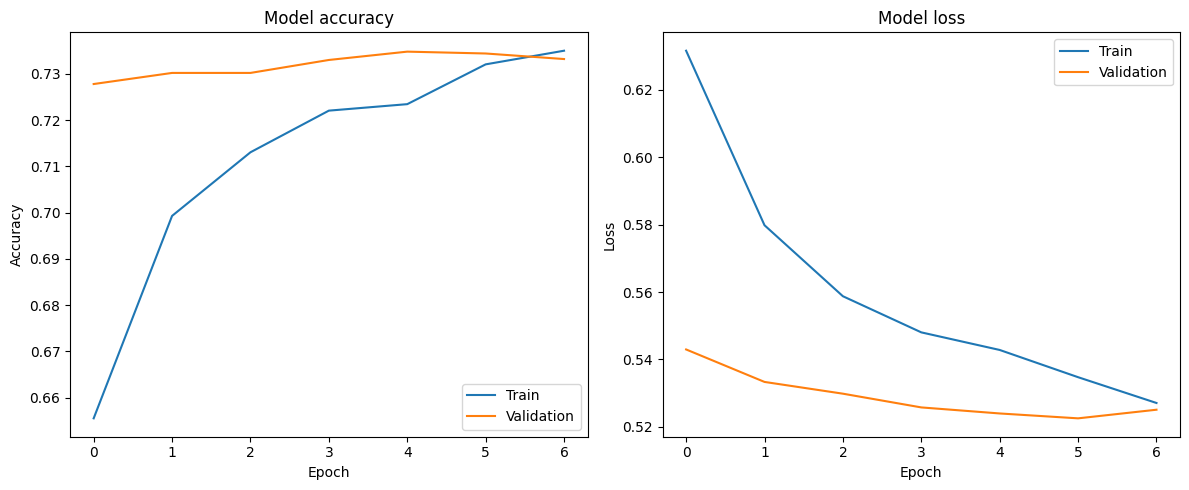

In [ ]:
# Plot training history
try:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot history: {e}")

In [ ]:
# 1.5 Evaluate the performance of your model on the test set
# Prepare test data for evaluation
test_data_subset = test_data.take(100)
test_processed = preprocess_dataset(test_data_subset)

# Evaluate the model
print("Evaluating model...")
results = classifier.evaluate(test_processed)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

Evaluating model...
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 383ms/step - accuracy: 0.7228 - loss: 0.5356
Test Loss: 0.5332
Test Accuracy: 0.7262


In [ ]:
# Function to make predictions on new text
def predict_sentiment(texts):
    # Make sure texts is a list
    if isinstance(texts, str):
        texts = [texts]

    # Preprocess texts
    preprocessed = preprocessor(texts)

    # Get BERT outputs
    bert_output = bert_model(preprocessed)
    encoder_outputs = bert_output['encoder_outputs']

    # Pool and combine outputs from all layers
    pooled_outputs = []
    for layer_output in encoder_outputs:
        pooled = tf.reduce_mean(layer_output, axis=1)
        pooled_outputs.append(pooled)

    combined = tf.concat(pooled_outputs, axis=-1)

    # Make prediction
    return classifier.predict(combined)

In [ ]:
# Test with example reviews
sample_reviews = [
    "This movie was fantastic! Great acting and storyline.",
    "The film was excellent, with amazing performances by the entire cast.",
    "Terrible film. Complete waste of time and money.",
    "I hated this movie. The plot made no sense and the acting was terrible.", "An absolute masterpiece! The direction and cinematography were breathtaking.",
    "Loved every moment of it. The characters were so relatable and well-developed.",
    "Not my cup of tea. Found it boring and way too slow.",
    "It was just okay. Some parts were good, but overall it lacked depth.",
    "Incredible experience! The music score and visuals perfectly complemented the story.",
    "Awful. The dialogue was cringe-worthy, and the pacing was all over the place.",
    "One of the best movies I've seen in years. Highly recommend it!",
    "Meh, it was pretty average. Nothing memorable about it.",
    "The action scenes were mind-blowing, but the story fell flat.",
    "A complete disaster. I can't believe I wasted two hours on this."
]

predictions = predict_sentiment(sample_reviews)

for i, review in enumerate(sample_reviews):
    sentiment = "Positive" if predictions[i][0] > 0.5 else "Negative"
    confidence = predictions[i][0] if sentiment == "Positive" else 1 - predictions[i][0]
    print(f"Review: {review}")
    print(f"Prediction: {sentiment} (confidence: {confidence:.4f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
Review: This movie was fantastic! Great acting and storyline.
Prediction: Positive (confidence: 0.9115)

Review: The film was excellent, with amazing performances by the entire cast.
Prediction: Positive (confidence: 0.9954)

Review: Terrible film. Complete waste of time and money.
Prediction: Negative (confidence: 0.6918)

Review: I hated this movie. The plot made no sense and the acting was terrible.
Prediction: Negative (confidence: 0.9612)

Review: An absolute masterpiece! The direction and cinematography were breathtaking.
Prediction: Positive (confidence: 0.7618)

Review: Loved every moment of it. The characters were so relatable and well-developed.
Prediction: Negative (confidence: 0.8135)

Review: Not my cup of tea. Found it boring and way too slow.
Prediction: Positive (confidence: 0.5296)

Review: It was just okay. Some parts were good, but overall it lacked depth.
Prediction: Negative (confidence: 0.9245)

Review: Incredible experience!

In [ ]:
print(f"Total training samples: {sum(1 for _ in train_data)}")

Total training samples: 313


In [ ]:
import tensorflow_datasets as tfds
train_data, test_data = tfds.load("imdb_reviews", split=["train", "test"], as_supervised=True)
print(f"Train dataset size: {len(list(train_data))}")


Train dataset size: 25000
